In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [100]:
def ReLu(x):
    return np.maximum(0,x)

def softmax(x):
    sum = 0
    for i in range(len(x)):
        sum += np.exp(x[i])
    return np.exp(x) / sum

def MaxPool(M):
    y,x,num_channels = M.shape
    i = 0
    j = 0
    output_height = (y - 3) // 2 + 1
    output_width = (x - 3) // 2 + 1
    print(f"output height: {output_height}, output width: {output_width}")
    output = np.zeros((output_height, output_width, num_channels))

    for c in range(num_channels):
        for i in range(0, output_height):
            for j in range(0, output_width):
                start_i, start_j = i * 2, j * 2
                region = M[start_i:start_i + 3, start_j:start_j + 3, c] #j'ai enlever output x et y car pas besoin et re for pour eviter de remettre à 0
                output[i, j, c] = np.max(region)
    return output

def MaxPool_v2(M):
    y,x,num_channels = M.shape
    i = 0
    j = 0
    output_height = y // 2
    output_width = x // 2
    output = np.zeros((output_height, output_width, num_channels))
    for c in range(num_channels):
        for i in range(0, output_height):
            for j in range(0, output_width):
                start_i, start_j = i * 2, j * 2
                if (start_i + 3 > y):
                    if(start_j + 3 > x):
                        region = M[start_i:y, start_j:start_j + 3, c]
                    else:
                        region = M[start_i:y, start_j:x, c]
                elif (start_j + 3 > x):
                    region = M[start_i:start_i + 3, start_j:x, c]
                else:
                    region = M[start_i:start_i + 3, start_j:start_j + 3, c] #j'ai enlever output x et y car pas besoin et re for pour eviter de remettre à 0
                output[i, j, c] = np.max(region)
    return output

def convolution(image, Ks, biais):
    image_height, image_width, image_channels = image.shape
    K_height, K_width, _, num_filters = Ks.shape
    output_height = image_height
    output_width = image_width
    output = np.zeros((output_height, output_width, num_filters))
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='constant')

    for f in range(num_filters):
        conv_sum = np.zeros((output_height, output_width))
        for c in range(image_channels):
            for i in range(output_height):
                for j in range(output_width):
                    region = padded_image[i:i+K_height, j:j+K_width, c]
                    conv_sum[i, j] += np.sum(region * Ks[:, :, c, f])
        output[:, :, f] = ReLu(conv_sum + biais[f])

    return output

def c_reshape(M):
    height, width, channels = M.shape
    output = M
    return output.reshape(height*width*channels) # On garde comme ça pour l'instant mais à changer pour le matériel

def FCP(M, weights, bias): # Fully Connected Perceptron
    '''
    M : (180,)
    weights : (180, 10)
    bias : (10,)
    output : (10,)
    '''
    M = M.T
    output = softmax(M.dot(weights) + bias)
    return output

def FCP_bis(M, weights, bias): # Fully Connected Perceptron
    '''
    M : (180,)
    weights : (180, 10)
    bias : (10,)
    output : (10,)
    '''
    # M = M.T
    weights = weights.T
    output = softmax(weights.dot(M) + bias)
    return output

def normalize(M):
    min_val = np.min(M)
    max_val = np.max(M)
    
    M_normalized = (M - min_val) / (max_val - min_val)
    
    return M_normalized

def normalize_image(I):
    N = I.size
    mu = np.mean(I)
    sigma = np.std(I)
    print(f"Moyenne {mu} ------- sigma {sigma}")

    normalized = (I - mu) / max(sigma, 1 / np.sqrt(N))

    return normalized


def normalize_image_bis(I):
    N = 24*24*3
    mean_value = np.mean(I)  # manually calculate mean using for loop
    total = 0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            for k in range(I.shape[2]):
                total += I[i, j, k]
    mean_value = total / N
    
    # Manually calculate variance
    variance = 0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            for k in range(I.shape[2]):
                variance += (I[i, j, k] - mean_value) ** 2
    sigma = np.sqrt(variance / N)
    
    print(f"Moyenne {mean_value} ------- sigma {sigma}")

    normalized = (I - mean_value) / max(sigma, 1 / np.sqrt(N))

    return normalized


def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        data = np.frombuffer(file.read(), dtype=np.uint8)
        
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:]
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    resized_images = np.array([image[3:27, 3:27] for image in images])
    return resized_images, labels

def load_class_names(file_path):
    with open(file_path, 'r') as file:
        class_names = [line.strip() for line in file]
    return class_names


def plot_sample_image(images, labels, class_names, index=0):
    image = images[index]
    label = labels[index]
    class_name = class_names[label]
    print(image.shape)
    plt.imshow(image)
    plt.title(f"Label: {label} ({class_name})")
    plt.axis('off')
    plt.show()

images, labels = load_cifar10_batch('../../Downloads/cifar10_data/cifar-10-batches-bin/test_batch.bin')
class_names = load_class_names('../../Downloads/cifar10_data/cifar-10-batches-bin/batches.meta.txt')


def process_tensor_data(tensor_name, raw_data):
    cleaned_string = raw_data.replace('[', '').replace(']', '').replace('\n', ' ')
    float_list = [float(x) for x in cleaned_string.split()]
    tensor_dict[tensor_name] = np.array(float_list)

tensor_dict = {}

with open('../../Downloads/CNN_coeff_3x3.txt', 'r') as file:
    tensor_name = None
    raw_data = ''
    
    for line in file:
        if line.startswith('tensor_name:'):
            if tensor_name:
                process_tensor_data(tensor_name, raw_data)
            tensor_name = line.split(':')[1].strip()
            raw_data = ''
        else:
            raw_data += line.strip() + '\n'
    
    if tensor_name:
        process_tensor_data(tensor_name, raw_data)

def reshape_array_parameters():
    for tensor_name, parameter_array in tensor_dict.items():
        if tensor_name == 'conv1/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(64,)
        elif tensor_name == 'conv1/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 3, 64)
        elif tensor_name == 'conv2/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(32,)
        elif tensor_name == 'conv2/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 64, 32)
        elif tensor_name == 'conv3/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(20,)
        elif tensor_name == 'conv3/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 32, 20)
        elif tensor_name == 'local3/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(10,)
        elif tensor_name == 'local3/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(180, 10)

reshape_array_parameters()

def plot_predict_image(images, labels, class_names, predict, confiance, index):
    image = images[index]
    label = labels[index]
    class_name = class_names[label]
    predict_class = class_names[predict]
    plt.imshow(image)
    plt.title(f"Label: {label} ({class_name})\n Predict: {predict} ({predict_class}) \n Confiance: {confiance}")
    plt.axis('off')
    plt.show()

def plot_images(images, labels, class_names, predictions, confidences, indices, num_images):
    cols = 3  # Number of images per row
    rows = (num_images + cols - 1) // cols  # Calculate number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case of single row
    
    for i, idx in enumerate(indices):
        image = images[idx]
        label = labels[idx]
        class_name = class_names[label]
        predict_class = class_names[predictions[i]]
        index_max = predictions[i]
        confidence = confidences[i][index_max]

        axes[i].imshow(image)
        axes[i].set_title(
            f"Label: {label} ({class_name})\n"
            f"Predict: {predictions[i]} ({predict_class})\n"
            f"Confidence: {confidence:.2f}"
        )
        axes[i].axis('off')
    
    # Turn off unused axes if num_images isn't a multiple of cols
    for j in range(len(indices), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def predict(begin, end):
    i = begin
    correct = 0
    indices = []
    indexes_max = []
    outputs = []
    while (i <= end):
        input_image = images[i]
        input_image = normalize_image(input_image)
        # input_image = normalize_image_bis(input_image)
        k1 = tensor_dict['conv1/weights']
        biais1 = tensor_dict['conv1/biases']
        k2 = tensor_dict['conv2/weights']
        biais2 = tensor_dict['conv2/biases']
        k3 = tensor_dict['conv3/weights']
        biais3 = tensor_dict['conv3/biases']
        weights_fcp = tensor_dict['local3/weights']
        biais_fcp = tensor_dict['local3/biases']

        conv1 = convolution(input_image, k1, biais1)
        maxpool1 = MaxPool_v2(conv1)
        conv2 = convolution(maxpool1, k2, biais2)
        maxpool2 = MaxPool_v2(conv2)
        conv3 = convolution(maxpool2, k3, biais3)
        maxpool3 = MaxPool_v2(conv3)
        reshape = c_reshape(maxpool3)
        output = FCP_bis(reshape, weights_fcp, biais_fcp)
        outputs.append(output)
        index_max = np.argmax(output)
        indexes_max.append(index_max)
        print(index_max)
        # plot_predict_image(images, labels, class_names, index_max, output[index_max], i)
        indices.append(i)
    

        if index_max == labels[i]:
            correct = correct + 1
        i = i + 1
    num_images = end-begin
    plot_images(images, labels, class_names, indexes_max, outputs, indices, num_images)
    reussite = correct / (end - begin)
    print(f"pourcentage reussite: {reussite*100}%")

Moyenne 114.0949074074074 ------- sigma 46.46140644535328
5
Moyenne 160.72627314814815 ------- sigma 73.78565336876147
8
Moyenne 143.8622685185185 ------- sigma 49.27401898268169
1
Moyenne 163.9820601851852 ------- sigma 48.24693213635922
8
Moyenne 115.22164351851852 ------- sigma 39.168706437225026
6
Moyenne 100.75983796296296 ------- sigma 49.71452842062223
6
Moyenne 90.64236111111111 ------- sigma 68.28813282822935
1
Moyenne 92.68981481481481 ------- sigma 43.04036744261526
6
Moyenne 165.92534722222223 ------- sigma 36.91200567666137
3


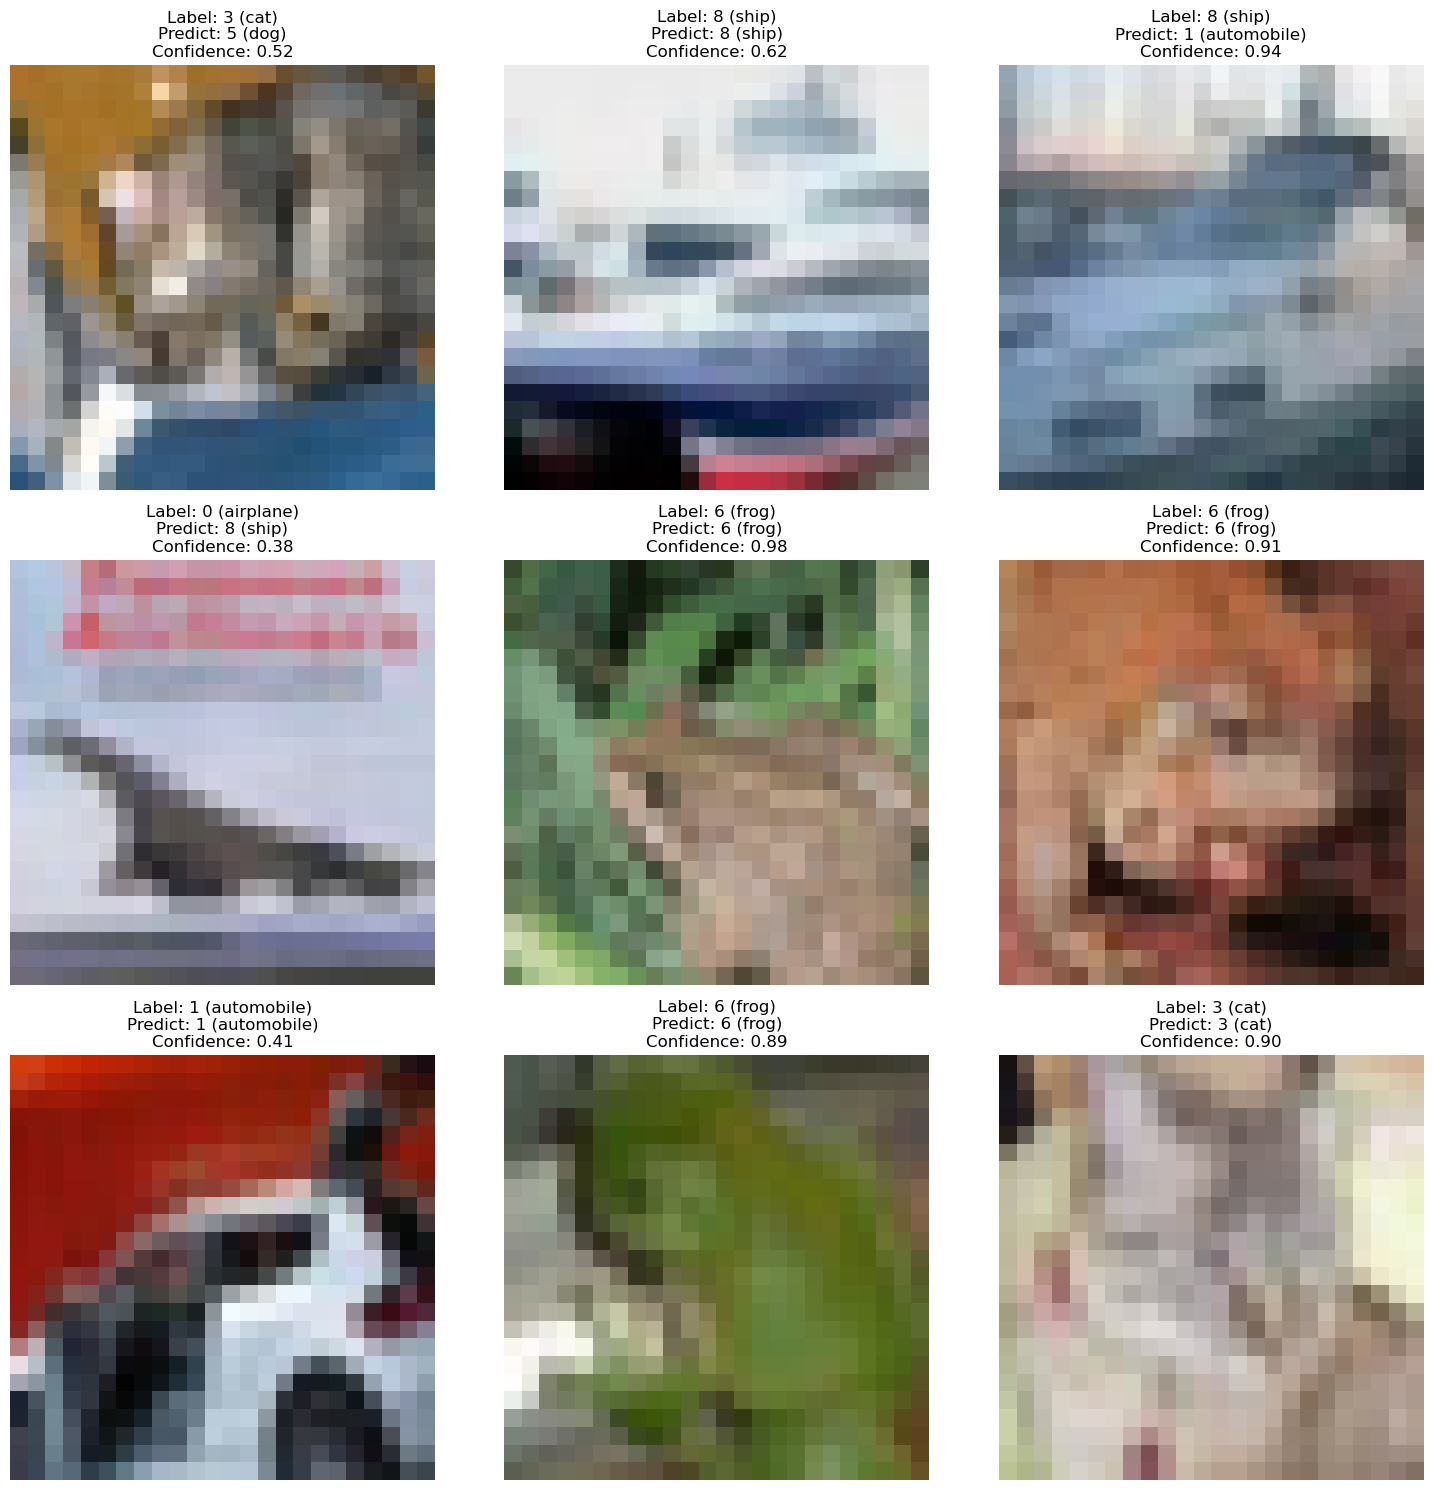

pourcentage reussite: 75.0%


In [101]:
predict(0, 8)